In [17]:
import os
import tqdm
import torch
import numpy as np
import pickle
from torchvision.models import resnet50

In [6]:
model = resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  
model.cuda()
model.eval()

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [8]:
image_folder = "processed_images/"
features = {}

# img_file = "{id}.npy"
for img_file in tqdm.tqdm(os.listdir(image_folder), total=len(os.listdir(image_folder)), desc="Extracting features"):
	book_id = img_file.split(".")[0]
	img_path = os.path.join(image_folder, img_file)
	img = np.load(img_path)
	img_tensor = torch.from_numpy(img).unsqueeze(0).cuda()
	
	with torch.no_grad():
		feature = model(img_tensor).squeeze()
		feature = feature.cpu().numpy()
		features[book_id] = feature

Extracting features: 100%|██████████| 13539/13539 [02:09<00:00, 104.78it/s]


In [9]:
with open("image_features.pkl", "wb") as f:
    pickle.dump(features, f)

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

with open("image_features.pkl", "rb") as f:
    features = pickle.load(f)

product_ids = list(features.keys())
feature_matrix = np.array(list(features.values()))

similarity_matrix = cosine_similarity(feature_matrix)

def get_similar_products(product_id, top_k=5):
    idx = product_ids.index(product_id)
    similar_indices = np.argsort(similarity_matrix[idx])[::-1][1:top_k+1]
    return [product_ids[i] for i in similar_indices]

print(get_similar_products("2"))


['6676', '821', '12285', '12969', '8456']


In [12]:
import json

recommendations = {}
for product_id in product_ids:
    recommendations[product_id] = get_similar_products(product_id)

with open("recommendations.json", "w") as f:
    json.dump(recommendations, f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7582842..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


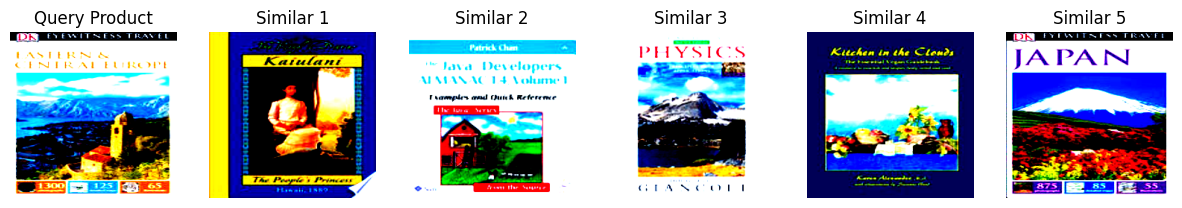

In [48]:
from PIL import Image
import matplotlib.pyplot as plt

def load_image(img_path):
	img = np.load(img_path)
	img = np.transpose(img, (1, 2, 0))
	return img

def plot_recommendations(product_id):
	img_path = os.path.join(image_folder, f"{product_id}.npy")

	if not os.path.exists(img_path):
		print(f"Query image not found: Book {product_id} doesn't exist.")
		return

	similar_products = get_similar_products(product_id)
	img = load_image(img_path)
	
	fig, axes = plt.subplots(1, len(similar_products) + 1, figsize=(15, 5))
	axes[0].imshow(img)
	axes[0].set_title("Query Product")
	axes[0].axis("off")

	for i, similar_id in enumerate(similar_products):
		img_path = os.path.join(image_folder, f"{similar_id}.npy")
		img = load_image(img_path)
		axes[i + 1].imshow(img)
		axes[i + 1].set_title(f"Similar {i+1}")
		axes[i + 1].axis("off")
		
	plt.show()

plot_recommendations("2")
